In [1]:
import pandas as pd
import numpy as np

import spacy
import pl_core_news_md

import nltk
import string,nltk,re
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer

from scikitplot.estimators import plot_learning_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline

In [2]:
df= pd.read_csv("sentyment_train_data_AS.csv")
df.head()

,text,stars
0,DM BOŚ obniżył wycenę akcji do 231 zł,-1
1,zaprezentuje 30 marca nową strategię,1
2,Selvita Giełdową Spółką Roku. zdetronizowany,-1
3,Giełdowa mizeria trwa. Notowania blisko roczn...,-1
4,przesuwa daty publikacji raportów finansowych...,-1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1309 non-null   object
 1   stars   1309 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.6+ KB


## Raiting

In [4]:
df['raiting'] = df['stars']
df.head()

,text,stars,raiting
0,DM BOŚ obniżył wycenę akcji do 231 zł,-1,-1
1,zaprezentuje 30 marca nową strategię,1,1
2,Selvita Giełdową Spółką Roku. zdetronizowany,-1,-1
3,Giełdowa mizeria trwa. Notowania blisko roczn...,-1,-1
4,przesuwa daty publikacji raportów finansowych...,-1,-1


In [5]:
df['raiting'].replace(-1, 0, inplace=True)
df.head()

,text,stars,raiting
0,DM BOŚ obniżył wycenę akcji do 231 zł,-1,0
1,zaprezentuje 30 marca nową strategię,1,1
2,Selvita Giełdową Spółką Roku. zdetronizowany,-1,0
3,Giełdowa mizeria trwa. Notowania blisko roczn...,-1,0
4,przesuwa daty publikacji raportów finansowych...,-1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     1309 non-null   object
 1   stars    1309 non-null   int64 
 2   raiting  1309 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 30.8+ KB


In [7]:
df['raiting'].value_counts()

1    916
0    393
Name: raiting, dtype: int64

<AxesSubplot:ylabel='raiting'>

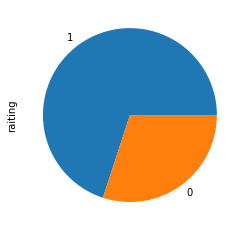

In [8]:
df['raiting'].value_counts().plot.pie()

In [9]:
df = df.sort_values(['raiting'], ascending=False, ignore_index=True)
df.head()

,text,stars,raiting
0,PKN analizuje wpływ brudnej ropy na instalacje...,1,1
1,Rada wierzycieli Ruchu przychylnie o planie re...,1,1
2,Fitch: Przejęcie Lotosu neutralne dla ratingu,1,1
3,Trigon DM podwyższył rekomendację Lotosu do ku...,1,1
4,Aviation chce zbudować skład paliw na lotnisk...,1,1


In [10]:
df = df.drop(df.index[:523])

<AxesSubplot:ylabel='raiting'>

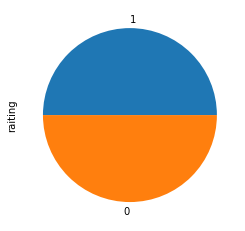

In [11]:
df['raiting'].value_counts().plot.pie()

In [12]:
df['raiting'].value_counts()

1    393
0    393
Name: raiting, dtype: int64

## Clean and preprocessing text data

In [13]:
nlp = pl_core_news_md.load()

In [14]:
text = 'jestem, byłam, będę, zostałam papieżem'

In [15]:
doc = nlp(text)
print(doc)

jestem, byłam, będę, zostałam papieżem


In [16]:
for token in doc:
    print(token, token.lemma, token.lemma_)

jestem 16756628963928444993 być
, 2593208677638477497 ,
byłam 16756628963928444993 być
, 2593208677638477497 ,
będę 14730050699322248679 będę
, 2593208677638477497 ,
zostałam 14711605111751778545 zostać
papieżem 884425083588738853 papież


In [17]:
df['text'].head()

523    GPW: 25 października 2017 r. odbędzie się osta...
524    PKN liczy  że w całym '17 marża downstream będ...
525    Przejęcie kontroli nad Unipetrolem bez wpływu ...
526               Latem auta elektryczne zatankują na ie
527       KNF zatwierdziła aneks do prospektu obligacji 
Name: text, dtype: object

In [18]:
df['new_text'] = df['text'].str.replace('[^\w\s]','')
df['new_text'].head()

523    GPW 25 października 2017 r odbędzie się ostatn...
524    PKN liczy  że w całym 17 marża downstream będz...
525    Przejęcie kontroli nad Unipetrolem bez wpływu ...
526               Latem auta elektryczne zatankują na ie
527       KNF zatwierdziła aneks do prospektu obligacji 
Name: new_text, dtype: object

In [19]:
def clean_text(text):
    doc = nlp(text)
    lemma_list=[]
    for token in doc:
        lemma_list.append(token.lemma_)

    return lemma_list

In [20]:
df['new_text'] = df['new_text'].apply(clean_text)
df.head()

,text,stars,raiting,new_text
523,GPW: 25 października 2017 r. odbędzie się osta...,1,1,"[gpw, 25, październik, 2017, r, odbyć, się, os..."
524,PKN liczy że w całym '17 marża downstream będ...,1,1,"[pkn, liczyć, , że, w, cały, 17, marża, downs..."
525,Przejęcie kontroli nad Unipetrolem bez wpływu ...,1,1,"[przejęcie, kontrola, nad, unipetrolem, bez, w..."
526,Latem auta elektryczne zatankują na ie,1,1,"[lato, auto, elektryczny, zatankować, na, ie]"
527,KNF zatwierdziła aneks do prospektu obligacji,1,1,"[knf, zatwierdzić, aneks, do, prospekt, obliga..."


In [21]:
df['liststring'] = df['new_text'].apply(lambda x: ','.join(map(str, x)))
df['liststring'].head()

523    gpw,25,październik,2017,r,odbyć,się,ostatni,dz...
524    pkn,liczyć, ,że,w,cały,17,marża,downstream,będ...
525    przejęcie,kontrola,nad,unipetrolem,bez,wpływ,n...
526               lato,auto,elektryczny,zatankować,na,ie
527          knf,zatwierdzić,aneks,do,prospekt,obligacja
Name: liststring, dtype: object

In [22]:
df['new_text2'] = df['liststring'].str.replace('[^\w\s]',' ')
df['new_text2'].head()

523    gpw 25 październik 2017 r odbyć się ostatni dz...
524    pkn liczyć   że w cały 17 marża downstream będ...
525    przejęcie kontrola nad unipetrolem bez wpływ n...
526               lato auto elektryczny zatankować na ie
527          knf zatwierdzić aneks do prospekt obligacja
Name: new_text2, dtype: object

## Polish stopwords

In [23]:
stopwords = pd.read_csv("stopwords.csv")
stopwords.head()

,id,stopwords
0,1,aby
1,2,ach
2,3,acz
3,4,aczkolwiek
4,5,aj


In [24]:
stopset = stopwords['stopwords'].tolist()
print(stopset)

['aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala', 'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna', 'jednak', 'jednakze', 'jednakże', 'jedno', 'je

## Counting the Frequency of words in a pandas data frame

In [25]:
top_N = 100

In [26]:
a = df['new_text2'].str.cat(sep=' ')

In [27]:
words = nltk.tokenize.word_tokenize(a)
word_dist = nltk.FreqDist(words)

In [28]:
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

In [29]:
print(rslt)

        Word  Frequency
0          w        315
1         na        207
2         do        187
3          z        147
4          i        115
..       ...        ...
95   wartość         12
96      opis         11
97      ciąg         11
98  wiatrowy         11
99    Bałtyk         11

[100 rows x 2 columns]


In [30]:
FreqDist = rslt['Word'].tolist()
print(FreqDist)

['w', 'na', 'do', 'z', 'i', 'zł', 'u', 'o', 'marża', 'lotos', 'akcja', 'nie', 'obajtek', 'mln', 'za', 'mld', 'ropa', 'dla', 'cena', 'cyberpunk', 'chcieć', 'od', 'być', 'mieć', 'dm', '2077', 'stacja', 'projekt', 'się', 'downstream', 'rok', 'paliwo', 'spółka', 'prezes', 'rekomendacja', 'przejęcie', 'sprzedaż', 'baryłka', 'proc', 'spaść', 'instalacja', 'usd', 'fuzja', 'ws', 'energi', 'obniżyć', 'po', 'ke', 'r', 'kw', 'ostrołęka', 'koniec', 'kwartał', 'pgnig', 'wzrość', 'grupa', 'obligacja', 'że', '1', 'budowa', 'docelowy', 'rozpocząć', 'nowy', 'ok', 'umowa', 'gra', 'obniżać', 'kolejny', 'zysk', 'pierwszy', 'wezwanie', 'sprzedać', 'to', 'inwestycja', '20', 'boś', 'spadek', 'móc', 'państwo', 'rafineryjny', 'farma', 'zakup', 'płyn', 'termin', 'dywidenda', 'c', 'będzie', 'nad', 'Płocko', 'Polska', 'dezynfekcja', 'pkn', 'liczyć', '17', 'wysoki', 'wartość', 'opis', 'ciąg', 'wiatrowy', 'Bałtyk']


In [31]:
newStopWords = ['obajtek', 'lotos', 'cyberpunk', '2077', '19', '17', '18', 'unipetrolu', 'pkn', '1', 
                'Polska', 'Płocko', 'pgnig', 'usd']
print(newStopWords)

['obajtek', 'lotos', 'cyberpunk', '2077', '19', '17', '18', 'unipetrolu', 'pkn', '1', 'Polska', 'Płocko', 'pgnig', 'usd']


## New stopwords

In [32]:
newstopset = stopset + newStopWords
print(newstopset)

['aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ', 'ani', 'az', 'aż', 'bardziej', 'bardzo', 'beda', 'bedzie', 'bez', 'deda', 'będą', 'bede', 'będę', 'będzie', 'bo', 'bowiem', 'by', 'byc', 'być', 'byl', 'byla', 'byli', 'bylo', 'byly', 'był', 'była', 'było', 'były', 'bynajmniej', 'cala', 'cali', 'caly', 'cała', 'cały', 'ci', 'cie', 'ciebie', 'cię', 'co', 'cokolwiek', 'cos', 'coś', 'czasami', 'czasem', 'czemu', 'czy', 'czyli', 'daleko', 'dla', 'dlaczego', 'dlatego', 'do', 'dobrze', 'dokad', 'dokąd', 'dosc', 'dość', 'duzo', 'dużo', 'dwa', 'dwaj', 'dwie', 'dwoje', 'dzis', 'dzisiaj', 'dziś', 'gdy', 'gdyby', 'gdyz', 'gdyż', 'gdzie', 'gdziekolwiek', 'gdzies', 'gdzieś', 'go', 'i', 'ich', 'ile', 'im', 'inna', 'inne', 'inny', 'innych', 'iz', 'iż', 'ja', 'jak', 'jakas', 'jakaś', 'jakby', 'jaki', 'jakichs', 'jakichś', 'jakie', 'jakis', 'jakiś', 'jakiz', 'jakiż', 'jakkolwiek', 'jako', 'jakos', 'jakoś', 'ją', 'je', 'jeden', 'jedna', 'jednak', 'jednakze', 'jednakże', 'jedno', 'je

## Text Vectorization

In [33]:
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=newstopset)

In [34]:
y = df['raiting']

In [35]:
X = vectorizer.fit_transform(df.new_text2)

/home/anna_s/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bya', 'byo', 'byy', 'caa', 'cay', 'maja', 'mao', 'okoo', 'pocko', 'polska', 'sa', 'tez', 'totoba', 'wasnie', 'wedug', 'wiec', 'wiecej', 'zosta'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2021)

## Naive Bayes

In [37]:
clf = naive_bayes.MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [38]:
predict = clf.predict(X_test)

In [39]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       115
           1       0.76      0.77      0.76       121

    accuracy                           0.75       236
   macro avg       0.75      0.75      0.75       236
weighted avg       0.75      0.75      0.75       236



In [40]:
confusion_matrix(y_test, predict)

array([[85, 30],
       [28, 93]])

In [41]:
scoring = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
scoring

0.8369385555156307

In [42]:
predict_prob = clf.predict_proba(X_test)[:,1]
print(predict_prob)

[0.6096302  0.60903072 0.25574327 0.16035002 0.43307763 0.54112775
 0.46366691 0.39293192 0.68897034 0.56092808 0.54088857 0.46228845
 0.62494907 0.3468155  0.3571752  0.58321902 0.49317725 0.65169367
 0.25071964 0.49378813 0.48964302 0.35944117 0.38548676 0.49261634
 0.77068829 0.56386151 0.59312013 0.59626439 0.6678831  0.39628625
 0.28530607 0.91657526 0.12003726 0.34321495 0.45846545 0.48620642
 0.56040512 0.52597451 0.66611375 0.652445   0.17113576 0.35721415
 0.48202529 0.59848893 0.34404398 0.55727538 0.81696781 0.60146717
 0.73510444 0.48664613 0.38782731 0.80749752 0.50028055 0.54260455
 0.4194744  0.39294953 0.6168263  0.27748823 0.49670799 0.72234924
 0.55444369 0.7303678  0.64662295 0.45336314 0.26653591 0.63319293
 0.23300356 0.50683021 0.79424146 0.56721118 0.28819956 0.38658554
 0.17246586 0.70753908 0.6564243  0.53408671 0.62094127 0.63162788
 0.59460387 0.65061597 0.38812409 0.71365906 0.50131893 0.30817006
 0.37026653 0.64111328 0.47911879 0.1035464  0.43071989 0.5681

In [43]:
predict_train = clf.predict(X_train)

In [44]:
print(classification_report(y_train, predict_train))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       278
           1       0.98      0.96      0.97       272

    accuracy                           0.97       550
   macro avg       0.97      0.97      0.97       550
weighted avg       0.97      0.97      0.97       550



In [45]:
confusion_matrix(y_train, predict_train)

array([[273,   5],
       [ 11, 261]])

In [46]:
scoring_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1])
scoring_train 

0.9917279411764705

In [47]:
predict_prob_train = clf.predict_proba(X_train)[:,1]
print(predict_prob)

[0.6096302  0.60903072 0.25574327 0.16035002 0.43307763 0.54112775
 0.46366691 0.39293192 0.68897034 0.56092808 0.54088857 0.46228845
 0.62494907 0.3468155  0.3571752  0.58321902 0.49317725 0.65169367
 0.25071964 0.49378813 0.48964302 0.35944117 0.38548676 0.49261634
 0.77068829 0.56386151 0.59312013 0.59626439 0.6678831  0.39628625
 0.28530607 0.91657526 0.12003726 0.34321495 0.45846545 0.48620642
 0.56040512 0.52597451 0.66611375 0.652445   0.17113576 0.35721415
 0.48202529 0.59848893 0.34404398 0.55727538 0.81696781 0.60146717
 0.73510444 0.48664613 0.38782731 0.80749752 0.50028055 0.54260455
 0.4194744  0.39294953 0.6168263  0.27748823 0.49670799 0.72234924
 0.55444369 0.7303678  0.64662295 0.45336314 0.26653591 0.63319293
 0.23300356 0.50683021 0.79424146 0.56721118 0.28819956 0.38658554
 0.17246586 0.70753908 0.6564243  0.53408671 0.62094127 0.63162788
 0.59460387 0.65061597 0.38812409 0.71365906 0.50131893 0.30817006
 0.37026653 0.64111328 0.47911879 0.1035464  0.43071989 0.5681

In [48]:
test = pd.read_csv('alldata_202104062221.csv', sep = ';')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85576 entries, 0 to 85575
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   content           85576 non-null  object
 1   company_name      85576 non-null  object
 2   publication_date  85576 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [49]:
test.sample(10)

,content,company_name,publication_date
48214,Kosztowna budowa nowych dróg,ERBUD,2011-03-02 06:27
84929,PGNiG jednocześnie współpracuje i spiera się z...,PGNIG,2013-06-21 05:30
64152,"PZU ocenia, że ma około 4 mld zł nadwyżkowego ...",PZU,2013-08-27 09:22
13564,"""Polskie KFC"" warte więcej od Tauronu",AMREST,2016-07-25 11:50
50341,Średnia cena kontraktu na dostawy energii w '1...,GPW,2016-04-04 11:12
78457,"DM BZ WBK rekomenduje ""sprzedaj"" PKN Orlen, ce...",PKNORLEN,2018-01-30 11:52
9636,Boryszew prowadzi kilka wstępnych rozmów ws. p...,BORYSZEW,2019-01-15 18:58
50262,Średnia cena kontraktu na dostawy energii w '1...,GPW,2016-11-04 08:25
48596,"""Podatek handlowy najbardziej uderzy w CCC i LPP""",EUROCASH,2016-04-28 10:01
25915,"DM BZ WBK rekomenduje ""kupuj"" Open Finance, ce...",OPENFIN,2014-06-18 14:03


In [50]:
test['new_text'] = test['content'].apply(clean_text)

In [51]:
test['liststring'] = test['new_text'].apply(lambda x: ','.join(map(str, x)))

In [52]:
test['new_text2'] = test['liststring'].str.replace('[^\w\s]',' ')

In [53]:
comments = test['new_text2']
comments

0        alt sa   1 2019   sprawozdanie rada nadzorczy ...
1        alt sa   2 2018   sprawozdanie rada nadzorczy ...
2        alt sa   1 2018   alt spółka akcyjny raport do...
3        alt sa   2 2017   sprawozdanie rada nadzorczy ...
4        alt sa   1 2017   alt spółka akcyjny raport do...
                               ...                        
85571    Szubsk   w 2011 r   pgnig móc sprzedać ponad 1...
85572    sejm   lasa móc udostępnić teren operator ener...
85573    uokik   zgoda na koncentracja spółka i wspólny...
85574                  grupa tauron aktualizować strategia
85575    pgnig   ure zgodzić się na obniżka cena gaz śr...
Name: new_text2, Length: 85576, dtype: object

In [54]:
comments_vector = vectorizer.transform(comments)

In [55]:
results = clf.predict(comments_vector)
results

array([0, 0, 0, ..., 1, 1, 0])

In [56]:
probability = clf.predict_proba(comments_vector)[:, 1]
probability 

array([0.38263036, 0.38222113, 0.47124675, ..., 0.78171109, 0.69465794,
       0.38673394])

In [57]:
test = test.drop('new_text', axis=1)
test = test.drop('liststring', axis=1)
test = test.drop('new_text2', axis=1)

In [58]:
test['results'] = results
test.head()

,content,company_name,publication_date,results
0,ALTA SA (1/2019) Sprawozdanie Rady Nadzorczej ...,ALTA,2019-05-09 13:56,0
1,ALTA SA (2/2018) Sprawozdanie Rady Nadzorczej ...,ALTA,2018-05-18 11:50,0
2,ALTA SA (1/2018) ALTA Spółka Akcyjna Raport do...,ALTA,2018-04-16 15:04,0
3,ALTA SA (2/2017) Sprawozdanie Rady Nadzorczej ...,ALTA,2017-05-24 16:04,0
4,ALTA SA (1/2017) ALTA Spółka Akcyjna Raport do...,ALTA,2017-04-24 17:10,1


In [59]:
test['probability'] = probability
test.head()

,content,company_name,publication_date,results,probability
0,ALTA SA (1/2019) Sprawozdanie Rady Nadzorczej ...,ALTA,2019-05-09 13:56,0,0.382630
1,ALTA SA (2/2018) Sprawozdanie Rady Nadzorczej ...,ALTA,2018-05-18 11:50,0,0.382221
2,ALTA SA (1/2018) ALTA Spółka Akcyjna Raport do...,ALTA,2018-04-16 15:04,0,0.471247
3,ALTA SA (2/2017) Sprawozdanie Rady Nadzorczej ...,ALTA,2017-05-24 16:04,0,0.443146
4,ALTA SA (1/2017) ALTA Spółka Akcyjna Raport do...,ALTA,2017-04-24 17:10,1,0.514730


In [60]:
test.to_csv('nlp.csv',  sep = ';')

In [61]:
nlp = pd.read_csv('nlp.csv', sep = ';')
nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85576 entries, 0 to 85575
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        85576 non-null  int64  
 1   content           85576 non-null  object 
 2   company_name      85576 non-null  object 
 3   publication_date  85576 non-null  object 
 4   results           85576 non-null  int64  
 5   probability       85576 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 3.9+ MB


In [62]:
nlp.head()

,Unnamed: 0,content,company_name,publication_date,results,probability
0,0,ALTA SA (1/2019) Sprawozdanie Rady Nadzorczej ...,ALTA,2019-05-09 13:56,0,0.382630
1,1,ALTA SA (2/2018) Sprawozdanie Rady Nadzorczej ...,ALTA,2018-05-18 11:50,0,0.382221
2,2,ALTA SA (1/2018) ALTA Spółka Akcyjna Raport do...,ALTA,2018-04-16 15:04,0,0.471247
3,3,ALTA SA (2/2017) Sprawozdanie Rady Nadzorczej ...,ALTA,2017-05-24 16:04,0,0.443146
4,4,ALTA SA (1/2017) ALTA Spółka Akcyjna Raport do...,ALTA,2017-04-24 17:10,1,0.514730
